<font size="5">**CS 178 Final Project - Random Forest**</font>

By: Sydnee Tan

### Setting Up Data Sets

In [2]:
import requests           
from io import StringIO

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import zero_one_loss as J01
import numpy as np
feature_list = ["age", "workclass", "fnlwgt", "education", "education-num", 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per=week', 'native-country']


In [3]:
# getting training data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

with requests.get(url) as link:
    datafile = StringIO(link.text)
    
    adults_X = []
    adults_y = []
    for line in datafile:
        split_line = line[:-1].split(', ')
        if len(split_line) == 15:
            adults_X.append([x if x != '?' else np.nan for x in split_line[:-1]])
            adults_y.append([split_line[-1]])

    # Since not all of the inputs are numbers (there is categorical data), we need to use
    # an ordinal encoder which will translate these into integers
    ord_enc = OrdinalEncoder()
    # we are going to use the encoded_missing_value parameter to encode missing values as well,
    # this sets any missing values (?) to -1
    adults_X = ord_enc.set_params(encoded_missing_value=-1).fit_transform(adults_X)
    
    label_enc = LabelEncoder()
    adults_y = label_enc.fit_transform(adults_y)

In [4]:
# getting test data
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

with requests.get(test_url) as link:
    datafile = StringIO(link.text)
    
    adults_test_X = []
    adults_test_y = []
    for line in datafile:
        split_line = line[:-1].split(', ')
        if len(split_line) == 15:
            adults_test_X.append([x if x != '?' else np.nan for x in split_line[:-1]])
            adults_test_y.append([split_line[-1]])

    # Since not all of the inputs are numbers (there is categorical data), we need to use
    # an ordinal encoder which will translate these into integers
    ord_enc = OrdinalEncoder()
    # we are going to use the encoded_missing_value parameter to encode missing values as well,
    # this sets any missing values (?) to -1
    adults_test_X = ord_enc.set_params(encoded_missing_value=-1).fit_transform(adults_test_X)
    
    label_enc = LabelEncoder()
    adults_test_y = label_enc.fit_transform(adults_test_y)

In [5]:
adults_X = np.asarray(adults_X)
adults_y = np.asarray(adults_y)
adults_X_te = np.asarray(adults_test_X)
adults_y_te = np.asarray(adults_test_y)

# split training validation 
adults_X_tr, adults_X_va, adults_y_tr, adults_y_va = train_test_split(adults_X, adults_y, 
                                                                  test_size=0.25, random_state=1234, shuffle=True)

### Data Exploration

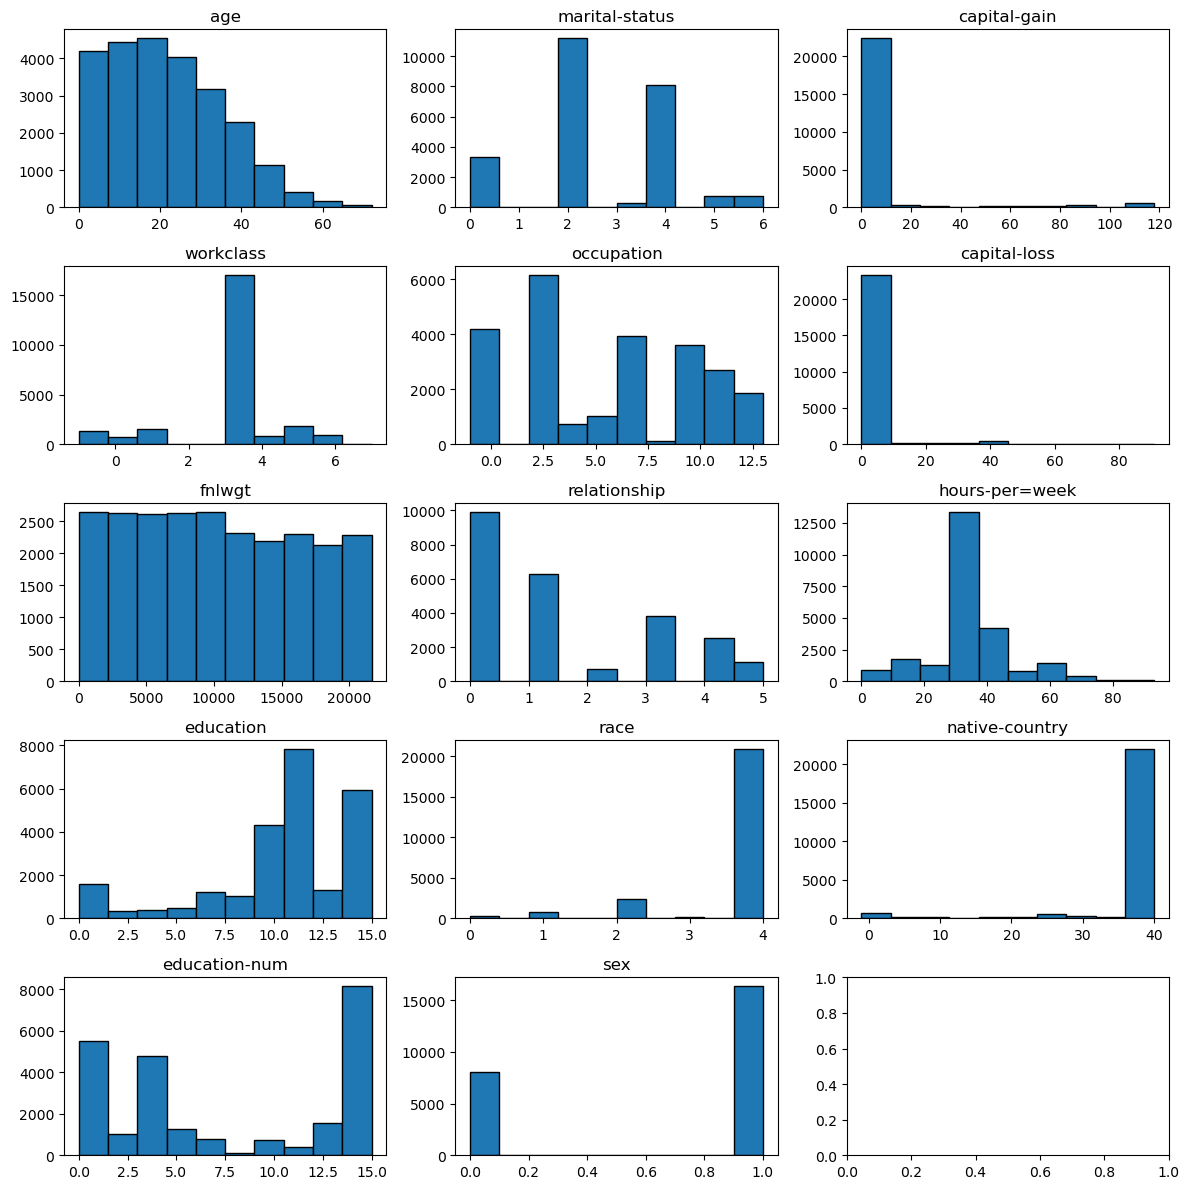

In [6]:
# Print out distribution of features
fig, axes = plt.subplots(5, 3, figsize=(12,12))  

for i in range(0,14):
    axes[i%5, i//5 ].hist(adults_X_tr[:,i], edgecolor='black')

    axes[i%5, i//5 ].set_title(feature_list[i])

fig.tight_layout()

In [7]:
# See how default random forest classifier does on training and validation
# 100 trees, gini, max_depth = None, min_samples_split =2, min_samples_leaf = 1, bootstrap=true, max_features=sqrt
RFC = RandomForestClassifier(random_state=1234).fit(adults_X_tr, adults_y_tr)
adults_y_tr_hat = RFC.predict(adults_X_tr)
adults_y_va_hat = RFC.predict (adults_X_va)

print(f"Training Error: {J01(adults_y_tr_hat, adults_y_tr)}")
print(f"Validation Error: {J01(adults_y_va_hat, adults_y_va)}")

# a lot of overfitting going on :'(

Training Error: 4.095004095006072e-05
Validation Error: 0.15391229578675836


In [9]:
# see if using entropy is any better than gini index
RFC = RandomForestClassifier(random_state=1234, criterion="entropy").fit(adults_X_tr, adults_y_tr)
adults_y_tr_hat = RFC.predict(adults_X_tr)
adults_y_va_hat = RFC.predict (adults_X_va)

print(f"Training Error: {J01(adults_y_tr_hat, adults_y_tr)}")
print(f"Validation Error: {J01(adults_y_va_hat, adults_y_va)}")

# slightly better, will use entropy from now on

Training Error: 0.0
Validation Error: 0.1528067804937968


### Tuning Parameters for Basic Model

In [79]:
# first adjust min_samples_leaf and min_samples_split to reduce overfitting
errors = []
combinations = []

for split in [5,10,25, 50, 100]:
    for leaf in [2,3,5,10]:
        if leaf < split:
            RFC = RandomForestClassifier(criterion="entropy",min_samples_split=split, min_samples_leaf=leaf,random_state=1234)
            RFC.fit(adults_X_tr, adults_y_tr)

            adults_y_hat = RFC.predict(adults_X_tr)
            adults_yv_hat = RFC.predict (adults_X_va)
            errors.append((J01(adults_y_hat, adults_y_tr), J01(adults_yv_hat, adults_y_va)))
            combinations.append((split, leaf))
    
for ((split, leaf), (training_error, validation_error)) in zip(combinations, errors):
    print(f"Min Samples Split: {split:3}, Min Samples Leaf: {leaf:2}, Training Error: {training_error:.4}, Validation Error: {validation_error:.4}")

Min Samples Split:   5, Min Samples Leaf:  2, Training Error: 0.05979, Validation Error: 0.1489
Min Samples Split:   5, Min Samples Leaf:  3, Training Error: 0.08395, Validation Error: 0.1474
Min Samples Split:  10, Min Samples Leaf:  2, Training Error: 0.07752, Validation Error: 0.1479
Min Samples Split:  10, Min Samples Leaf:  3, Training Error: 0.09046, Validation Error: 0.1458
Min Samples Split:  10, Min Samples Leaf:  5, Training Error: 0.1054, Validation Error: 0.1478
Min Samples Split:  25, Min Samples Leaf:  2, Training Error: 0.09984, Validation Error: 0.1476
Min Samples Split:  25, Min Samples Leaf:  3, Training Error: 0.107, Validation Error: 0.1472
Min Samples Split:  25, Min Samples Leaf:  5, Training Error: 0.1137, Validation Error: 0.1474
Min Samples Split:  25, Min Samples Leaf: 10, Training Error: 0.1249, Validation Error: 0.1507
Min Samples Split:  50, Min Samples Leaf:  2, Training Error: 0.1136, Validation Error: 0.149
Min Samples Split:  50, Min Samples Leaf:  3, T

Text(0.5, 0, 'Max Depth')

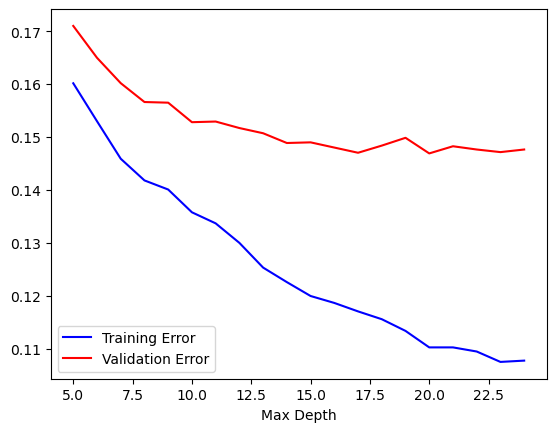

In [80]:
# try adjusting max_depth

training_errors = []
validation_errors = []

for i in range(5,25):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_depth=i,min_samples_split=25, min_samples_leaf=3)
    RFC.fit(adults_X_tr, adults_y_tr)

    adults_y_hat = RFC.predict(adults_X_tr)
    adults_yv_hat = RFC.predict (adults_X_va)
    training_errors.append(J01(adults_y_hat, adults_y_tr))
    validation_errors.append(J01(adults_yv_hat, adults_y_va))
    
plt.plot([i for i in range(5,25)], training_errors, color='blue')
plt.plot([i for i in range(5,25)], validation_errors, color="red")
plt.legend(["Training Error", "Validation Error"], loc='lower left')
plt.xlabel("Max Depth")



In [81]:
for depth, error in zip([i for i in range(5,25)], validation_errors):
    print(f"Depth: {depth:2}, Validation Error: {error:.4}")

Depth:  5, Validation Error: 0.171
Depth:  6, Validation Error: 0.165
Depth:  7, Validation Error: 0.1602
Depth:  8, Validation Error: 0.1566
Depth:  9, Validation Error: 0.1565
Depth: 10, Validation Error: 0.1528
Depth: 11, Validation Error: 0.1529
Depth: 12, Validation Error: 0.1517
Depth: 13, Validation Error: 0.1507
Depth: 14, Validation Error: 0.1489
Depth: 15, Validation Error: 0.149
Depth: 16, Validation Error: 0.148
Depth: 17, Validation Error: 0.147
Depth: 18, Validation Error: 0.1484
Depth: 19, Validation Error: 0.1499
Depth: 20, Validation Error: 0.1469
Depth: 21, Validation Error: 0.1483
Depth: 22, Validation Error: 0.1476
Depth: 23, Validation Error: 0.1472
Depth: 24, Validation Error: 0.1476


Max Features: 1, Validation Error: 0.1578
Max Features: 2, Validation Error: 0.1523
Max Features: 3, Validation Error: 0.1507
Max Features: 4, Validation Error: 0.1495
Max Features: 5, Validation Error: 0.1472
Max Features: 6, Validation Error: 0.1468
Max Features: 7, Validation Error: 0.1458
Max Features: 8, Validation Error: 0.1442
Max Features: 9, Validation Error: 0.1436
Max Features: 10, Validation Error: 0.1437
Max Features: 11, Validation Error: 0.1426
Max Features: 12, Validation Error: 0.144
Max Features: 13, Validation Error: 0.1425
Max Features: 14, Validation Error: 0.1427


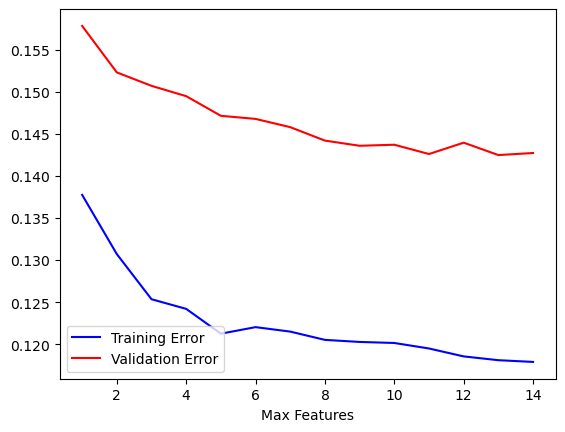

In [84]:
# playing around with max_features, default is sqrt of number of features

training_errors = []
validation_errors = []

for i in range(1,15):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_features=i, max_depth=13,min_samples_split=25, min_samples_leaf=3)
    RFC.fit(adults_X_tr, adults_y_tr)

    adults_y_hat = RFC.predict(adults_X_tr)
    adults_yv_hat = RFC.predict (adults_X_va)
    training_errors.append(J01(adults_y_hat, adults_y_tr))
    validation_errors.append(J01(adults_yv_hat, adults_y_va))
    
plt.plot([i for i in range(1,15)], training_errors, color='blue')
plt.plot([i for i in range(1,15)], validation_errors, color="red")
plt.legend(["Training Error", "Validation Error"], loc='lower left')
plt.xlabel("Max Features")

for feature, error in zip([i for i in range(1,15)], validation_errors):
    print(f"Max Features: {feature}, Validation Error: {error:.4}")

### Feature Transformation Model

In [15]:
# see which features are most influential on classifier 

#source code: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
RFC = RandomForestClassifier(random_state=1234, criterion="entropy").fit(adults_X_tr, adults_y_tr)

importances = list(RFC.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: -x[1])

for feature, importance in feature_importances:
    print(f"{feature:20}: {importance}")

age                 : 0.17
fnlwgt              : 0.17
relationship        : 0.1
hours-per=week      : 0.09
marital-status      : 0.08
capital-gain        : 0.08
education-num       : 0.07
occupation          : 0.07
workclass           : 0.04
education           : 0.04
capital-loss        : 0.03
race                : 0.02
sex                 : 0.02
native-country      : 0.02


Text(0.5, 0, 'Features Transform')

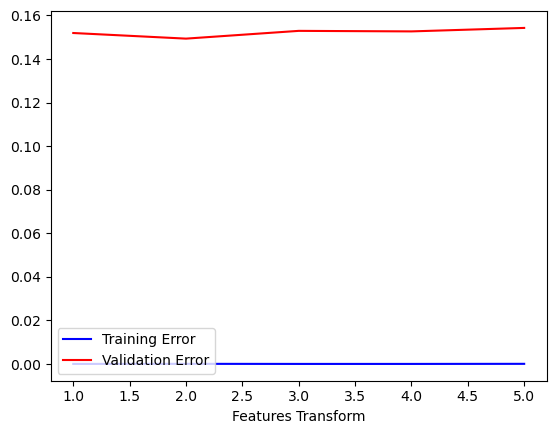

In [10]:
# observe how feature transformations will affect the classifier

degrees = [1,2,3,4,5]
training_errors = []
validation_errors = []

for degree in degrees:
    
    # Create a polynomial feature expansion of degree d
    poly = PolynomialFeatures(degree=degree).fit(adults_X_tr)
    XtrP = poly.transform(adults_X_tr)
    XvaP = poly.transform(adults_X_va)
    
    RFC = RandomForestClassifier(random_state=1234, criterion="entropy").fit(XtrP, adults_y_tr)
    
    adults_y_tr_hat = RFC.predict(XtrP)
    adults_y_va_hat = RFC.predict(XvaP)
    
    training_errors.append(J01(adults_y_tr_hat, adults_y_tr))
    validation_errors.append(J01(adults_y_va_hat, adults_y_va))
    
    ###  YOUR CODE ENDS HERE  ###    
plt.plot(degrees, training_errors, color='blue')
plt.plot(degrees, validation_errors, color="red")
plt.legend(["Training Error", "Validation Error"], loc='lower left')
plt.xlabel("Features Transform")

In [12]:
for degree, validation_error in zip(degrees, validation_errors):
    print(f"Feature Transform Degree: {degree} Validation Error: {validation_error}")

Feature Transform Degree: 1 Validation Error: 0.15194693526593783
Feature Transform Degree: 2 Validation Error: 0.1493673995823609
Feature Transform Degree: 3 Validation Error: 0.1529296155263481
Feature Transform Degree: 4 Validation Error: 0.15268394546124553
Feature Transform Degree: 5 Validation Error: 0.1542808008844122


Transforming features into a degree of 2 decreased error on the validation set by 0.3%, so we will use a polynomial transformation of 2 from now on. 

### Tuning Parameters for Feature Transformation Model

We will use polynomial degree 2 and see if we can reduce the validation error.

In [26]:
# first adjust min_samples_leaf and min_samples_split to reduce overfitting
errors = []
combinations = []

for split in [5,10,25, 50, 100]:
    for leaf in [2,3,5,10]:
        if leaf < split:
            RFC = RandomForestClassifier(criterion="entropy",min_samples_split=split, min_samples_leaf=leaf,random_state=1234)
            RFC.fit(adults_X2_tr, adults_y_tr)

            adults_y_hat = RFC.predict(adults_X2_tr)
            adults_yv_hat = RFC.predict (adults_X2_va)
            errors.append((J01(adults_y_hat, adults_y_tr), J01(adults_yv_hat, adults_y_va)))
            combinations.append((split, leaf))
    
for ((split, leaf), (training_error, validation_error)) in zip(combinations, errors):
    print(f"Min Samples Split: {split:3}, Min Samples Leaf: {leaf:2}, Training Error: {training_error:.4}, Validation Error: {validation_error:.4}")

Min Samples Split:   5, Min Samples Leaf:  2, Training Error: 0.01888, Validation Error: 0.1489
Min Samples Split:   5, Min Samples Leaf:  3, Training Error: 0.03747, Validation Error: 0.1486
Min Samples Split:  10, Min Samples Leaf:  2, Training Error: 0.04095, Validation Error: 0.148
Min Samples Split:  10, Min Samples Leaf:  3, Training Error: 0.05111, Validation Error: 0.1484
Min Samples Split:  10, Min Samples Leaf:  5, Training Error: 0.06806, Validation Error: 0.1478
Min Samples Split:  25, Min Samples Leaf:  2, Training Error: 0.07809, Validation Error: 0.149
Min Samples Split:  25, Min Samples Leaf:  3, Training Error: 0.08317, Validation Error: 0.1447
Min Samples Split:  25, Min Samples Leaf:  5, Training Error: 0.09173, Validation Error: 0.1475
Min Samples Split:  25, Min Samples Leaf: 10, Training Error: 0.1041, Validation Error: 0.1469
Min Samples Split:  50, Min Samples Leaf:  2, Training Error: 0.1024, Validation Error: 0.1449
Min Samples Split:  50, Min Samples Leaf:  3

Having a min_samples_split of 25 and a min_samples_leaf of 3 gave us a validation error of 14.47. We'll proceed with these parameters.

Text(0.5, 0, 'Max Depth')

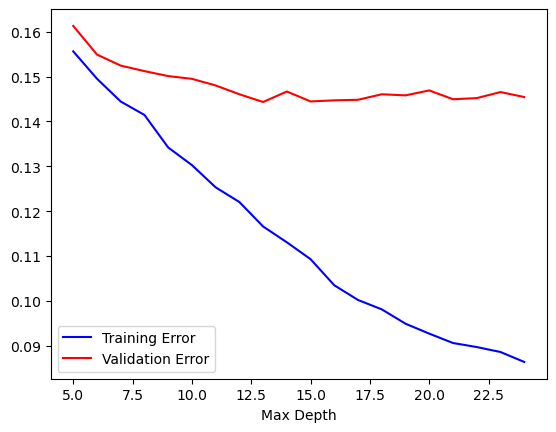

In [27]:
# try adjusting max_depth

training_errors = []
validation_errors = []

for i in range(5,25):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_depth=i,min_samples_split=25, min_samples_leaf=3)
    RFC.fit(adults_X2_tr, adults_y_tr)

    adults_y_hat = RFC.predict(adults_X2_tr)
    adults_yv_hat = RFC.predict (adults_X2_va)
    training_errors.append(J01(adults_y_hat, adults_y_tr))
    validation_errors.append(J01(adults_yv_hat, adults_y_va))
    
plt.plot([i for i in range(5,25)], training_errors, color='blue')
plt.plot([i for i in range(5,25)], validation_errors, color="red")
plt.legend(["Training Error", "Validation Error"], loc='lower left')
plt.xlabel("Max Depth")



In [29]:
for depth, error in zip([i for i in range(5,25)], validation_errors):
    print(f"Depth: {depth:2}, Validation Error: {error:.4}")
    

Depth:  5, Validation Error: 0.1613
Depth:  6, Validation Error: 0.1549
Depth:  7, Validation Error: 0.1524
Depth:  8, Validation Error: 0.1512
Depth:  9, Validation Error: 0.1501
Depth: 10, Validation Error: 0.1495
Depth: 11, Validation Error: 0.148
Depth: 12, Validation Error: 0.1461
Depth: 13, Validation Error: 0.1443
Depth: 14, Validation Error: 0.1467
Depth: 15, Validation Error: 0.1445
Depth: 16, Validation Error: 0.1447
Depth: 17, Validation Error: 0.1448
Depth: 18, Validation Error: 0.1461
Depth: 19, Validation Error: 0.1458
Depth: 20, Validation Error: 0.1469
Depth: 21, Validation Error: 0.1449
Depth: 22, Validation Error: 0.1452
Depth: 23, Validation Error: 0.1465
Depth: 24, Validation Error: 0.1454


Validation error seemed to plateau around max depth of 12, but the lowest was at max depth of 13 with a validation an error of .1443 - an all time low achieved by our model so far.

Text(0.5, 0, 'Max Features')

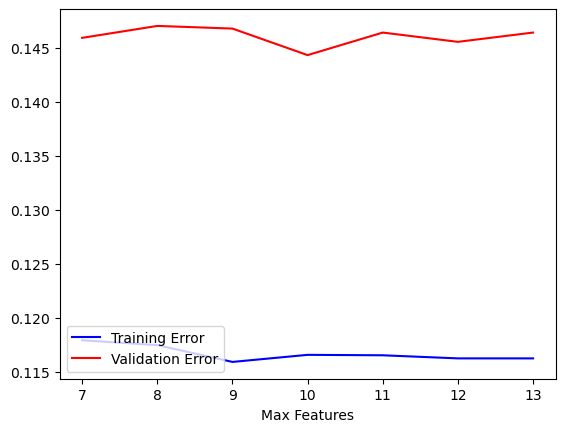

In [52]:
# playing around with max_features, default is sqrt of number of features

training_errors = []
validation_errors = []

for i in range(7,14):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_features=i, max_depth=13,min_samples_split=25, min_samples_leaf=3)
    RFC.fit(adults_X2_tr, adults_y_tr)

    adults_y_hat = RFC.predict(adults_X2_tr)
    adults_yv_hat = RFC.predict (adults_X2_va)
    training_errors.append(J01(adults_y_hat, adults_y_tr))
    validation_errors.append(J01(adults_yv_hat, adults_y_va))
    
plt.plot([i for i in range(7,14)], training_errors, color='blue')
plt.plot([i for i in range(7,14)], validation_errors, color="red")
plt.legend(["Training Error", "Validation Error"], loc='lower left')
plt.xlabel("Max Features")

In [54]:
for feature, error in zip([i for i in range(7,14)], validation_errors):
    print(f"Max Features: {feature:2}, Validation Error: {error:.4}")

Max Features:  7, Validation Error: 0.1459
Max Features:  8, Validation Error: 0.147
Max Features:  9, Validation Error: 0.1468
Max Features: 10, Validation Error: 0.1443
Max Features: 11, Validation Error: 0.1464
Max Features: 12, Validation Error: 0.1456
Max Features: 13, Validation Error: 0.1464


Default of 10 max features for bootstrapping was resulted in the lowest validation error.

## Feature Reduction Model

In [56]:
poly = PolynomialFeatures(degree=2).fit(adults_X)
adults_X2_tr = poly.transform(adults_X_tr)
adults_X2_va = poly.transform(adults_X_va)
 
RFC = RandomForestClassifier(random_state=1234, criterion="entropy").fit(adults_X2_va, adults_y_va)
importances = list(RFC.feature_importances_)

feature_importances = [(index, round(importance, 2)) for index, importance in enumerate(importances)]

feature_importances = sorted(feature_importances, key = lambda x: -x[1])

print(feature_importances)

[(27, 0.03), (92, 0.03), (1, 0.02), (3, 0.02), (8, 0.02), (15, 0.02), (16, 0.02), (17, 0.02), (18, 0.02), (19, 0.02), (21, 0.02), (28, 0.02), (30, 0.02), (43, 0.02), (44, 0.02), (45, 0.02), (46, 0.02), (47, 0.02), (48, 0.02), (52, 0.02), (53, 0.02), (73, 0.02), (93, 0.02), (97, 0.02), (5, 0.01), (6, 0.01), (7, 0.01), (11, 0.01), (13, 0.01), (20, 0.01), (22, 0.01), (23, 0.01), (24, 0.01), (31, 0.01), (32, 0.01), (33, 0.01), (34, 0.01), (35, 0.01), (40, 0.01), (42, 0.01), (49, 0.01), (56, 0.01), (57, 0.01), (58, 0.01), (61, 0.01), (63, 0.01), (65, 0.01), (66, 0.01), (67, 0.01), (68, 0.01), (69, 0.01), (70, 0.01), (74, 0.01), (75, 0.01), (76, 0.01), (78, 0.01), (80, 0.01), (82, 0.01), (83, 0.01), (84, 0.01), (86, 0.01), (87, 0.01), (88, 0.01), (90, 0.01), (91, 0.01), (98, 0.01), (103, 0.01), (106, 0.01), (108, 0.01), (110, 0.01), (112, 0.01), (113, 0.01), (117, 0.01), (118, 0.01), (0, 0.0), (2, 0.0), (4, 0.0), (9, 0.0), (10, 0.0), (12, 0.0), (14, 0.0), (25, 0.0), (26, 0.0), (29, 0.0), (36

Some of the transformed features had close to no impact on the classifier so we will see if remove those features will remove any possible noise and improve on our validation set.

In [57]:
# new feature list
print(poly.get_feature_names_out(feature_list))

['1' 'age' 'workclass' 'fnlwgt' 'education' 'education-num'
 'marital-status' 'occupation' 'relationship' 'race' 'sex' 'capital-gain'
 'capital-loss' 'hours-per=week' 'native-country' 'age^2' 'age workclass'
 'age fnlwgt' 'age education' 'age education-num' 'age marital-status'
 'age occupation' 'age relationship' 'age race' 'age sex'
 'age capital-gain' 'age capital-loss' 'age hours-per=week'
 'age native-country' 'workclass^2' 'workclass fnlwgt'
 'workclass education' 'workclass education-num'
 'workclass marital-status' 'workclass occupation'
 'workclass relationship' 'workclass race' 'workclass sex'
 'workclass capital-gain' 'workclass capital-loss'
 'workclass hours-per=week' 'workclass native-country' 'fnlwgt^2'
 'fnlwgt education' 'fnlwgt education-num' 'fnlwgt marital-status'
 'fnlwgt occupation' 'fnlwgt relationship' 'fnlwgt race' 'fnlwgt sex'
 'fnlwgt capital-gain' 'fnlwgt capital-loss' 'fnlwgt hours-per=week'
 'fnlwgt native-country' 'education^2' 'education education-num'
 

In [58]:
# create new training and validation set with relevant features for reduction
for baseline in [0.0025, 0.005, 0.0075, 0.01, 0.012]:
    relevant_features = []
    for index, importance in feature_importances:
        if importance >= baseline:
            relevant_features.append(index)

    reduced_adults_X2_tr = adults_X2_tr[:, relevant_features]
    reduced_adults_X2_va = adults_X2_va[:, relevant_features]

    # see if there is any improvement in performance with reduced features
    RFC = RandomForestClassifier(random_state=1234, criterion="entropy")
    RFC.fit(reduced_adults_X2_tr, adults_y_tr)
    reduced_adults_y_tr_hat = RFC.predict(reduced_adults_X2_tr)
    reduced_adults_y_va_hat = RFC.predict (reduced_adults_X2_va)

    print(f"Training Error with feature importance < {baseline} removed: {J01(reduced_adults_y_tr_hat, adults_y_tr)}")
    print(f"Validation Error with feature importance < {baseline} removed: {J01(reduced_adults_y_va_hat, adults_y_va)}")

Training Error with feature importance < 0.0025 removed: 4.095004095006072e-05
Validation Error with feature importance < 0.0025 removed: 0.15735167669819428
Training Error with feature importance < 0.005 removed: 4.095004095006072e-05
Validation Error with feature importance < 0.005 removed: 0.15735167669819428
Training Error with feature importance < 0.0075 removed: 4.095004095006072e-05
Validation Error with feature importance < 0.0075 removed: 0.15735167669819428
Training Error with feature importance < 0.01 removed: 4.095004095006072e-05
Validation Error with feature importance < 0.01 removed: 0.15735167669819428
Training Error with feature importance < 0.012 removed: 4.095004095006072e-05
Validation Error with feature importance < 0.012 removed: 0.1852352290873357


Feature reduction seemed to increase the validation error overall, but we will keep feature reduction as an option in mind. Something else important to note is that features with importance less there appeared to be no difference as to whether we removed features with importances less than 0.0025 or 0.01. 

We will tune a model removing features of importance less than 0.01 and see if that improves upon the validation model.

### Tuning Parameters for Feature Transform + Reduction Model

In [73]:
# Remake the dataset with reduced features
relevant_features = []
for index, importance in feature_importances:
    if importance >= 0.01:
        relevant_features.append(index)

reduced_adults_X2_tr = adults_X2_tr[:, relevant_features]
reduced_adults_X2_va = adults_X2_va[:, relevant_features]

# check best combination of min_samples_leaf, min_samples_split
errors = []
combinations = []

for split in [5,10,25, 50, 100]:
    for leaf in [2,3,5,10]:
        if leaf < split:
            RFC = RandomForestClassifier(criterion="entropy",min_samples_split=split, min_samples_leaf=leaf,random_state=1234)
            RFC.fit(reduced_adults_X2_tr, adults_y_tr)

            adults_y_hat = RFC.predict(reduced_adults_X2_tr)
            adults_yv_hat = RFC.predict (reduced_adults_X2_va)
            errors.append((J01(adults_y_hat, adults_y_tr), J01(adults_yv_hat, adults_y_va)))
            combinations.append((split, leaf))
    
for ((split, leaf), (training_error, validation_error)) in zip(combinations, errors):
    print(f"Min Samples Split: {split:3}, Min Samples Leaf: {leaf:2}, Training Error: {training_error:.4}, Validation Error: {validation_error:.4}")

Min Samples Split:   5, Min Samples Leaf:  2, Training Error: 0.01675, Validation Error: 0.1548
Min Samples Split:   5, Min Samples Leaf:  3, Training Error: 0.03456, Validation Error: 0.156
Min Samples Split:  10, Min Samples Leaf:  2, Training Error: 0.04034, Validation Error: 0.1534
Min Samples Split:  10, Min Samples Leaf:  3, Training Error: 0.04943, Validation Error: 0.1534
Min Samples Split:  10, Min Samples Leaf:  5, Training Error: 0.06704, Validation Error: 0.1546
Min Samples Split:  25, Min Samples Leaf:  2, Training Error: 0.07981, Validation Error: 0.1527
Min Samples Split:  25, Min Samples Leaf:  3, Training Error: 0.08595, Validation Error: 0.1507
Min Samples Split:  25, Min Samples Leaf:  5, Training Error: 0.09378, Validation Error: 0.1522
Min Samples Split:  25, Min Samples Leaf: 10, Training Error: 0.1055, Validation Error: 0.1537
Min Samples Split:  50, Min Samples Leaf:  2, Training Error: 0.1047, Validation Error: 0.1519
Min Samples Split:  50, Min Samples Leaf:  

Min_samples_split of 25 and min_samples_leaf of 3 yielded the best results on the validation set with an error rate of .1507. This is higher than the error rate than without feature reduction. 

Text(0.5, 0, 'Max Depth')

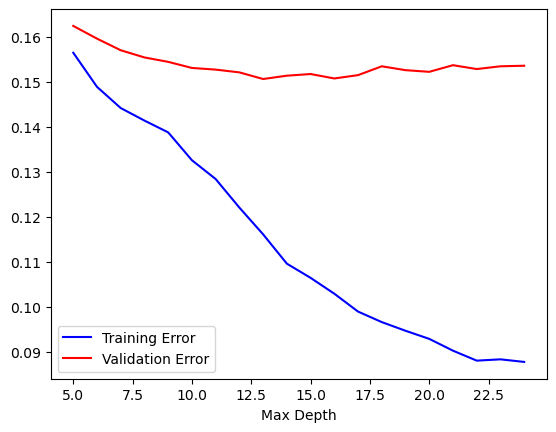

In [75]:
# try adjusting max_depth

training_errors = []
validation_errors = []

for i in range(5,25):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_depth=i,min_samples_split=25, min_samples_leaf=3)
    RFC.fit(reduced_adults_X2_tr, adults_y_tr)

    adults_y_hat = RFC.predict(reduced_adults_X2_tr)
    adults_yv_hat = RFC.predict(reduced_adults_X2_va)
    training_errors.append(J01(adults_y_hat, adults_y_tr))
    validation_errors.append(J01(adults_yv_hat, adults_y_va))
    
plt.plot([i for i in range(5,25)], training_errors, color='blue')
plt.plot([i for i in range(5,25)], validation_errors, color="red")
plt.legend(["Training Error", "Validation Error"], loc='lower left')
plt.xlabel("Max Depth")



In [77]:
for depth, error in zip([i for i in range(5,25)],validation_errors):
    print(f"Depth: {depth:2}, error: {error:.4}")

Depth:  5, error: 0.1624
Depth:  6, error: 0.1596
Depth:  7, error: 0.157
Depth:  8, error: 0.1554
Depth:  9, error: 0.1544
Depth: 10, error: 0.1531
Depth: 11, error: 0.1527
Depth: 12, error: 0.1521
Depth: 13, error: 0.1506
Depth: 14, error: 0.1513
Depth: 15, error: 0.1517
Depth: 16, error: 0.1507
Depth: 17, error: 0.1515
Depth: 18, error: 0.1534
Depth: 19, error: 0.1526
Depth: 20, error: 0.1522
Depth: 21, error: 0.1537
Depth: 22, error: 0.1528
Depth: 23, error: 0.1534
Depth: 24, error: 0.1535


Max Features:  5, Validation Error: 0.1518
Max Features:  6, Validation Error: 0.1517
Max Features:  7, Validation Error: 0.1519
Max Features:  8, Validation Error: 0.1506
Max Features:  9, Validation Error: 0.1484
Max Features: 10, Validation Error: 0.1501
Max Features: 11, Validation Error: 0.1491
Max Features: 12, Validation Error: 0.1495
Max Features: 13, Validation Error: 0.151
Max Features: 14, Validation Error: 0.148
Max Features: 15, Validation Error: 0.1507
Max Features: 16, Validation Error: 0.15
Max Features: 17, Validation Error: 0.1501
Max Features: 18, Validation Error: 0.1502
Max Features: 19, Validation Error: 0.1506
Max Features: 20, Validation Error: 0.1504
Max Features: 21, Validation Error: 0.15
Max Features: 22, Validation Error: 0.1508
Max Features: 23, Validation Error: 0.1505
Max Features: 24, Validation Error: 0.15
Max Features: 25, Validation Error: 0.1495
Max Features: 26, Validation Error: 0.1515
Max Features: 27, Validation Error: 0.1502
Max Features: 28, V

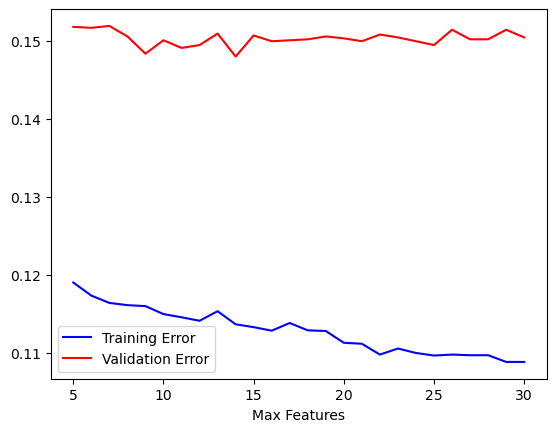

In [85]:
# playing around with max_features, default is sqrt of number of features

training_errors = []
validation_errors = []

for i in range(5,31):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_features=i, max_depth=13,min_samples_split=25, min_samples_leaf=3)
    RFC.fit(reduced_adults_X2_tr, adults_y_tr)

    adults_y_hat = RFC.predict(reduced_adults_X2_tr)
    adults_yv_hat = RFC.predict (reduced_adults_X2_va)
    training_errors.append(J01(adults_y_hat, adults_y_tr))
    validation_errors.append(J01(adults_yv_hat, adults_y_va))
    
plt.plot([i for i in range(5,31)], training_errors, color='blue')
plt.plot([i for i in range(5,31)], validation_errors, color="red")
plt.legend(["Training Error", "Validation Error"], loc='lower left')
plt.xlabel("Max Features")

for feature, error in zip([i for i in range(5,31)], validation_errors):
    print(f"Max Features: {feature:2}, Validation Error: {error:.4}")

## Testing

In [88]:
RFC = RandomForestClassifier().fit(adults_X_tr, adults_y_tr)
adults_y_hat = RFC.predict(adults_X_tr)
adults_yv_hat = RFC.predict (adults_X_va)
adults_yt_hat = RFC.predict(adults_X_te)
print(f"No Tuning Model Training Error: {J01(adults_y_hat, adults_y_tr)}")
print(f"No Tuning Model Validation Error: {J01(adults_yv_hat, adults_y_va)}")
print(f"No Tuning Model Testing Error: {J01(adults_yt_hat, adults_y_te)}")
print()

basicRFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_features=13, max_depth=13,min_samples_split=25, min_samples_leaf=3)
basicRFC.fit(adults_X_tr, adults_y_tr)

adults_y_hat = basicRFC.predict(adults_X_tr)
adults_yv_hat = basicRFC.predict (adults_X_va)
adults_yt_hat = basicRFC.predict(adults_X_te)

print(f"Basic Model Training Error: {J01(adults_y_hat, adults_y_tr)}")
print(f"Basic Model Validation Error: {J01(adults_yv_hat, adults_y_va)}")
print(f"Basic Model Testing Error: {J01(adults_yt_hat, adults_y_te)}")
print() 

adults_X2_te = poly.transform(adults_X_te)
transformRFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_features=10, max_depth=13,min_samples_split=25, min_samples_leaf=3)
transformRFC.fit(adults_X2_tr, adults_y_tr)

adults_y_hat = transformRFC.predict(adults_X2_tr)
adults_yv_hat = transformRFC.predict (adults_X2_va)
adults_yt_hat = transformRFC.predict(adults_X2_te)

print(f"Transformed Model Training Error: {J01(adults_y_hat, adults_y_tr)}")
print(f"Transformed Model Validation Error: {J01(adults_yv_hat, adults_y_va)}")
print(f"Transformed Model Testing Error: {J01(adults_yt_hat, adults_y_te)}")
print()

reduced_adults_X2_te =adults_X2_te[:, relevant_features]
reducedRFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_features=14, max_depth=13,min_samples_split=25, min_samples_leaf=3)
reducedRFC.fit(reduced_adults_X2_tr, adults_y_tr)

adults_y_hat = reducedRFC.predict(reduced_adults_X2_tr)
adults_yv_hat = reducedRFC.predict (reduced_adults_X2_va)
adults_yt_hat = reducedRFC.predict (reduced_adults_X2_te)
print(f"Reduced Model Training Error: {J01(adults_y_hat, adults_y_tr)}")
print(f"Reduced Model Validation Error: {J01(adults_yv_hat, adults_y_va)}")
print(f"Reduced Model Testing Error: {J01(adults_yt_hat, adults_y_te)}")
print()


No Tuning Model Training Error: 0.0
No Tuning Model Validation Error: 0.15243827539614296
No Tuning Model Testing Error: 0.15644002211166386

Basic Model Training Error: 0.11809991809991816
Basic Model Validation Error: 0.14248863775948906
Basic Model Testing Error: 0.15146489773355443

Transformed Model Training Error: 0.11658476658476657
Transformed Model Validation Error: 0.1443311632477583
Transformed Model Testing Error: 0.14845525459124131

Reduced Model Training Error: 0.11363636363636365
Reduced Model Validation Error: 0.14801621422429678
Reduced Model Testing Error: 0.15287758737178303

